In [1]:
#lo añadiré cuando sepa que todo funciona correctamente
#import LibreriaTFG as lib

In [1]:
import numpy as np  
from numpy import pi, cos, sin
import numpy.polynomial.legendre as npl
import sympy as sp
import matplotlib.pyplot as plt
from scipy.special import legendre
from scipy.interpolate import lagrange
import math 

In [2]:
def Transformation(nodes, weight,a,b):
    nodes=(b-a)/2*nodes+(a+b)/2
    weight=(b-a)/2 *weight
    return (nodes,weight)

def chop(lista):
    for i in range(len(lista)):
        if(abs(lista[i])<(10**(-10))):
            lista[i]=0
    return lista

class Cuadrature:
    def __init__(self,nodes=None,weight=None):
        if(list(nodes)!=None):
                self.nodes=nodes
        if(list(weight)!=None):
                self.weight=weight
        
    def getNodes(self):
        return self.nodes
    def getWeight(self):
        return self.weight
    def getNumPoints(self):
        return len(self.nodes)
    
    def Integrate(self,f):
        return self.Integrate_List(f(np.array(self.nodes)))
    
    def Integrate_List(self,lista):
        if (len(lista)==len(self.weight)):
            return np.array(lista).dot(np.array(self.weight))
        else:
            raise Exception("No has metido correctamente la lista")

class Lobato(Cuadrature):
    def __init__(self, num_points,a,b):
        aux=[-1,*sorted(list(legendre(num_points).deriv().r)),1]
        Cuadrature.__init__(self, nodes=np.array(aux), weight=np.array(2/(num_points*(num_points+1)*(legendre(num_points)(aux))**2)))
        self.nodes,self.weight=Transformation(self.nodes, self.weight, a, b)
    def __str__(self):
        return "Nodos: %s \nPesos: %s " %(self.nodes,self.weight)

class Legendre(Cuadrature):
    def __init__(self,num_points,a,b):
        Cuadrature.__init__(self,nodes=npl.leggauss(num_points)[0], weight=npl.leggauss(num_points)[1]) 
        self.nodes,self.weight=Transformation(self.nodes, self.weight, a, b)
    def __str__(self):
        return "Nodos: %s \nPesos: %s " %(self.nodes,self.weight)

class Trapecio_Compuesto(Cuadrature): #están considerados los extremos(-1,1)
    def __init__(self,num_points,a,b):
        Cuadrature.__init__(self, nodes=np.array([*np.arange(-1,1,float(2/num_points)).tolist(),1]), weight=np.array([2/(2*num_points),*[2/num_points]*(num_points-1),2/(2*num_points)]))
        self.nodes,self.weight=Transformation(self.nodes, self.weight, a, b)
    def __str__(self):
        return "Nodos: %s \nPesos: %s " %(self.nodes,self.weight)

def Funciones_Base(N):
    '''
    Crea las funciones bases de grado N y devuelve un vector con las funciones bases y otro con sus derivadas
    '''
    x = sp.symbols('x')
    xvals = chop(Lobato(N,-1,1).getNodes())
    
    aux=np.zeros(N+1)
    phi=[]
    difphi=[]
    
    for i in range(0,N+1):
        aux[i]=1
        phi.append((lambda x:lagrange(xvals,aux))(x))
        difphi.append((lambda x: lagrange(xvals,aux).deriv())(x))  
        aux=np.zeros(N+1)
    return (phi,difphi)

In [3]:
def M_Difusion(m,p,Nq,num_interval):
    '''
    Función que construye la matriz local en una dimensión que integra la derivada de funciones bases en su respectivo intervalo
    '''
    intervals=np.linspace(-1,1,m+1)
    A=np.zeros((p+1, p+1))
    a=intervals[num_interval-1]
    b=intervals[num_interval]
    xvals2 = chop(Lobato(Nq-1,-1,1).getNodes())
    phi,difphi=Funciones_Base(p)
    J=(b-a)/2
    
    for i in range(0,p+1):
        for j in range(0,p+1):
            A[i][j]=Lobato(Nq-1,a,b).Integrate_List((difphi[i](xvals2))/J*(difphi[j](xvals2)/J))
    
    return A

def M_Masa(m,p,Nq,num_interval):
    '''
    Función que construye la matriz local en una dimensión que integra las funciones bases en su respectivo intervalo
    '''
    intervals=np.linspace(-1,1,m+1)
    A=np.zeros((p+1, p+1))
    a=intervals[num_interval-1]
    b=intervals[num_interval]
    xvals2 = chop(Lobato(Nq-1,-1,1).getNodes())
    phi,difphi=Funciones_Base(p)
    
    for i in range(0,p+1):
        for j in range(0,p+1):
            A[i][j]=Lobato(Nq-1,a,b).Integrate_List(phi[i](xvals2)*phi[j](xvals2))
    
    return A

def V_Indep(m,p,Nq,num_interval,f): 
    '''
    Función que construye el vector independiente en su respectivo intervalo de la función unidimensional y la funciones bases
    '''
    intervals=np.linspace(-1,1,m+1)
    A=np.zeros(p+1)
    a=intervals[num_interval-1]
    b=intervals[num_interval]
    phi,difphi=Funciones_Base(p)
 
    xvals2 = chop(Lobato(Nq-1,-1,1).getNodes())
    xvals3 = chop(Lobato(Nq-1,a,b).getNodes())
    
    for i in range(0,p+1):
            A[i]=Lobato(Nq-1,a,b).Integrate_List(f(xvals3)*phi[i](xvals2))  
        
    return A

def M_Masa_Global_1D(m,p,Nq):#m es nº de intervalos
    
    AG=np.zeros((p*m+1, p*m+1))
    for k in range(0,m):
        A=M_Masa(m,p,Nq,k+1)
        for i in range(0,p+1):
            for j in range(0,p+1):
                AG[k*p+i][k*p+j] = AG[k*p+i][k*p+j] + A[i][j]
                #print("int",k+1,"k*p+i:",k*p+i," k*p+j:",k*p+j," k,i,j",k,i,j," sol:",AG[k*p+i][k*p+j] )
    return AG

def M_Difusion_Global_1D(m,p,Nq):#m es nº de intervalos
    
    AG=np.zeros((p*m+1, p*m+1))
    for k in range(0,m):
        A=M_Difusion(m,p,Nq,k+1)
        for i in range(0,p+1):
            for j in range(0,p+1):
                AG[k*p+i][k*p+j] = AG[k*p+i][k*p+j] + A[i][j]
                #print("int",k+1,"k*p+i:",k*p+i," k*p+j:",k*p+j," k,i,j",k,i,j," sol:",AG[k*p+i][k*p+j] )
    return AG

def V_Indep_Global_1D(m,p,Nq,f):#m es nº de intervalos
    
    BG=np.zeros(p*m+1)
    for k in range(0,m):
        B=V_Indep(m,p,Nq,k+1,f)
        for i in range(0,p+1):
            BG[k*p+i]=BG[k*p+i]+B[i]
                 #print("int",k+1,"k*p+i:",k*p+i," k*p+j:",k*p+j," k,i,j",k,i,j," sol:",AG[k*p+i][k*p+j] )
    return BG

def Solucion_1D(N_vals, Nq, f, cond1, cond2):
    AG=M_Difusion_Global_1D(N_vals,4,Nq) 
    BG=V_Indep_Global_1D(N_vals,4,Nq,f) 
    
    AG[0][0]=10**30
    BG[0]=cond1*10**30
    AG[len(AG)-1][len(AG)-1]=10**30
    BG[len(BG)-1]=cond2*10**30

    return np.linalg.solve(AG,BG)

def Indices(k,m):
    '''
    A partir de un número k (nodo k) obtenemos los índices (i,j) para saber a qué posición nos referimos
    Con la variable m indicamos el número de filas y columnas de la matriz total(consideramos matrices cuadradas)
    '''
    i=k%(m+1)
    j=k//(m+1)
    return (i,j)

def M_Global_2D(m,p,Nq):
    
    D=M_Difusion_Global_1D(m,p,Nq)
    M=M_Masa_Global_1D(m,p,Nq)
    A=np.zeros(((m*p+1)*(m*p+1),(m*p+1)*(m*p+1)))
    
    for k1 in range(0,(m*p+1)*(m*p+1)):
        i1,j1=Indices(k1,m*p)
        #print(" ")
        #print("k1: ",k1, "i1,j1: ",i1,j1)
        for k2 in range(0,(m*p+1)*(m*p+1)):
            i2,j2=Indices(k2,m*p)
            #print("k2: ",k2, "i2,j2: ",i2,j2 )
            A[k1][k2]=D[i1][i2]*M[j1][j2]+M[i1][i2]*D[j1][j2]
                        
    return A

def V_Indep_Global_2D(m,p,Nq,f1,f2): 
    
    B=V_Indep_Global_1D(m,p,Nq,f1)
    B1=V_Indep_Global_1D(m,p,Nq,f2)
    B2=np.zeros((m*p+1)*(m*p+1))
    
    for k in range(0,(m*p+1)*(m*p+1)):
        i1,j1=Indices(k,m*p)
        #print("i1,j1",i1,j1)
        B2[k]=B[i1]*B1[j1]
                        
    return B2

def bloquear(A,B,m,p):
    for i in range(0,m*p+1): #bloquea los nodos de la frontera inferior y superior, imponiendo la diagonal de los respectivos nodos
        A[i][i]=10**30
        A[(m*p+1)**2-1-i][(m*p+1)**2-1-i]=10**30
        B[i]=0
        B[(m*p+1)**2-1-i]=0
    for i in range(0,(m*p+1)**2): 
        if(i%(m*p+1)==0): #bloquea la frontera izquierda
            A[i][i]=10**30
            B[i]=0
        if((i+1)%(m*p+1)==0): #bloquea la frontera izquierda
            A[i][i]=10**30
            B[i]=0
    return (A,B)

def Solucion_2D(m,p,Nq,f1,f2):
    A=M_Global_2D(m,p,Nq)
    B=V_Indep_Global_2D(m,p,Nq,f1,f2)
    A,B=bloquear(A,B,m,p)
    U=np.linalg.solve(A,B)
    
    return U

## Ejemplos 1D : $-u''=f$

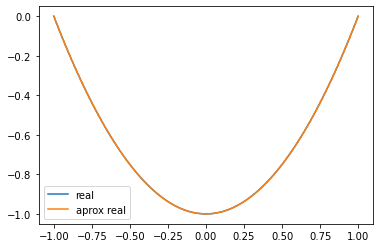

In [5]:
f= lambda x: -2
real = lambda x: x**2-1

N_vals=100 #Num intervalos
Nq=5 #nodos de cuadratura 
cond1=cond2=0
X = Solucion_1D(N_vals, Nq, f, cond1, cond2)

valores=np.linspace(-1,1,len(X))
plt.plot(valores,real(valores),label="real")
plt.plot(np.linspace(-1,1,len(X)),X,label="aprox real")
plt.legend()

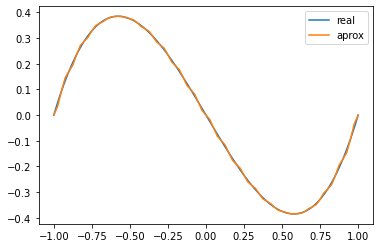

In [6]:
f= lambda x:-6*x
real= lambda x: x*(x+1)*(x-1) 

N_vals=20 #Num intervalos
Nq=5 #nodos de cuadratura 
cond1=cond2=0
X = Solucion_1D(N_vals, Nq, f, cond1, cond2)

valores=np.linspace(-1,1,101)
plt.plot(valores,real(valores),label="real")
plt.plot(np.linspace(-1,1,len(X)),X,label="aprox")
plt.legend()

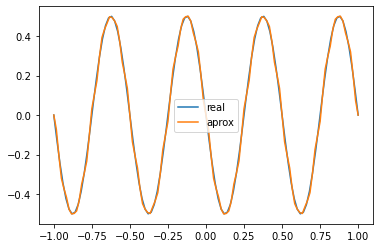

In [7]:
f= lambda x: -16*pi**2*cos(2*pi*x)*sin(2*pi*x)
real = lambda x: -sin(2*pi*x)*cos(2*pi*x)

N_vals=30 #Num intervalos
Nq=7 #nodos de cuadratura 
cond1=cond2=0
X = Solucion_1D(N_vals, Nq, f, cond1, cond2)

valores=np.linspace(-1,1,101)
plt.plot(valores,real(valores),label="real")
plt.plot(np.linspace(-1,1,len(X)),X,label="aprox")
plt.legend()

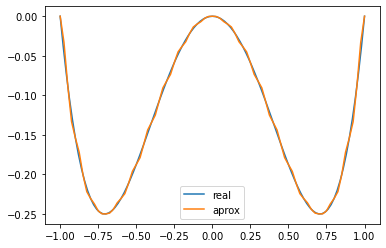

In [8]:
f=lambda x:2-12*x**2
real = lambda x:-x**2*(1 - x**2)

N_vals=20 #Num intervalos
Nq=20 #nodos de cuadratura 
cond1=cond2=0
X = Solucion_1D(N_vals, Nq, f, cond1, cond2)

valores=np.linspace(-1,1,101)
plt.plot(valores,real(valores),label="real")
plt.plot(np.linspace(-1,1,len(X)),X,label="aprox")
plt.legend()

### Ejemplos cuyas condiciones de contorno no son 0

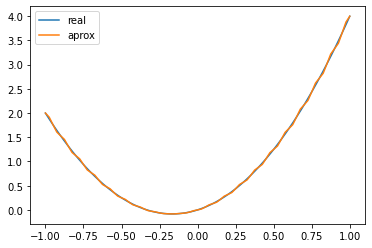

In [9]:
f= lambda x: -6
real = lambda x: 3*x**2+x

N_vals=20 #Num intervalos
Nq=5 #nodos de cuadratura 
cond1=2
cond2=4
X = Solucion_1D(N_vals, Nq, f, cond1, cond2)

valores=np.linspace(-1,1,101)
plt.plot(valores,real(valores),label="real")
plt.plot(np.linspace(-1,1,len(X)),X,label="aprox")
plt.legend()

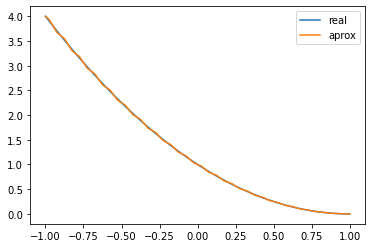

In [10]:
f= lambda x: -2
real = lambda x: (x-1)**2

N_vals=20 #Num intervalos
Nq=5 #nodos de cuadratura 
cond1=4
cond2=0
X = Solucion_1D(N_vals, Nq, f, cond1, cond2)

valores=np.linspace(-1,1,101)
plt.plot(valores,real(valores),label="real")
plt.plot(np.linspace(-1,1,len(X)),X,label="aprox")
plt.legend()

# Dimensión 2

# Probamos con grado 1

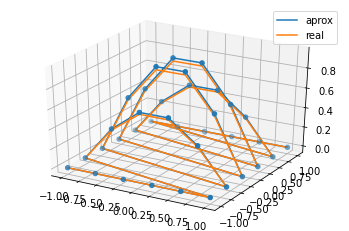

In [11]:
f1=lambda x: (1/math.sqrt(2))*(pi)*cos(pi/2*x)
#f2= lambda y: np.cos(np.pi/2*y)
g = lambda x,y: np.cos(np.pi/2 *x)*np.cos(np.pi/2 *y)

m=5
p=1
Nq=5
U=Solucion_2D(m,p,Nq,f1,f1)

fig = plt.figure()
ax = plt.axes(projection='3d')

i=[]
j=[]
real=[]
xvalss=np.linspace(-1,1,m*p+1)

for k in range(0,len(U)):
    i.append(xvalss[Indices(k,m*p)[0]])
    j.append(xvalss[Indices(k,m*p)[1]])
    real.append(g(i[k],j[k]))
    
ax.plot3D(i,j,U,label="aprox")
ax.scatter3D(i,j,U)
ax.plot3D(i,j,real,label="real")
plt.legend()
plt.show()   

In [12]:
err = U - real
print(f"Error ($||U-real||_\inf$): {max(abs(err))}")

Error ($||U-real||_\inf$): 0.03013184314102535


# Grado 2

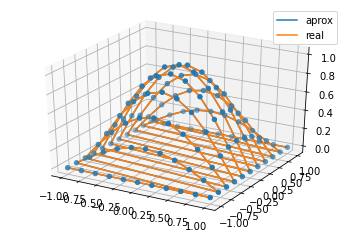

In [13]:
f1=lambda x: (1/math.sqrt(2))*(pi)*cos(pi/2*x)
#f2= lambda y: np.cos(np.pi/2*y)
g = lambda x,y: np.cos(np.pi/2 *x)*np.cos(np.pi/2 *y)

m=5
p=2
Nq=5
U=Solucion_2D(m,p,Nq,f1,f1)

fig = plt.figure()
ax = plt.axes(projection='3d')

i=[]
j=[]
real=[]
xvalss=np.linspace(-1,1,m*p+1)

for k in range(0,len(U)):
    i.append(xvalss[Indices(k,m*p)[0]])
    j.append(xvalss[Indices(k,m*p)[1]])
    real.append(g(i[k],j[k]))
    
ax.plot3D(i,j,U,label="aprox")
ax.scatter3D(i,j,U)
ax.plot3D(i,j,real,label="real")
plt.legend()
plt.show()   

In [14]:
err = U - real
print(f"Error ($||U-real||_\inf$): {max(abs(err))}")

Error ($||U-real||_\inf$): 0.00020345001038002408


# Con grado 3

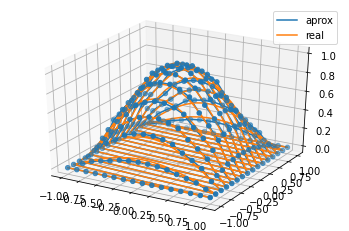

In [15]:
f1=lambda x: (1/math.sqrt(2))*(pi)*cos(pi/2*x)
#f2= lambda y: np.cos(np.pi/2*y)
g = lambda x,y: np.cos(np.pi/2 *x)*np.cos(np.pi/2 *y)

m=5
p=3
Nq=5
U=Solucion_2D(m,p,Nq,f1,f1)

fig = plt.figure()
ax = plt.axes(projection='3d')

i=[]
j=[]
real=[]
xvalss=np.linspace(-1,1,m*p+1)

for k in range(0,len(U)):
    i.append(xvalss[Indices(k,m*p)[0]])
    j.append(xvalss[Indices(k,m*p)[1]])
    real.append(g(i[k],j[k]))
    
ax.plot3D(i,j,U,label="aprox")
ax.scatter3D(i,j,U)
ax.plot3D(i,j,real,label="real")
plt.legend()
plt.show()   

In [16]:
err = U - real
print(f"Error ($||U-real||_\inf$): {max(abs(err))}")

Error ($||U-real||_\inf$): 0.03568190145188338


# Con grado 4

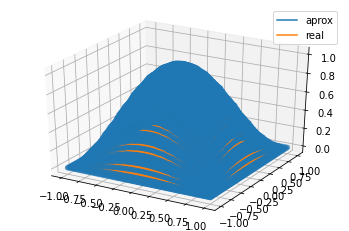

In [4]:
f1=lambda x: (1/math.sqrt(2))*(pi)*cos(pi/2*x)
#f2= lambda y: np.cos(np.pi/2*y)
g = lambda x,y: np.cos(np.pi/2 *x)*np.cos(np.pi/2 *y)

m=15
p=4
Nq=5
U=Solucion_2D(m,p,Nq,f1,f1)

fig = plt.figure()
ax = plt.axes(projection='3d')

i=[]
j=[]
real=[]
xvalss=np.linspace(-1,1,m*p+1)

for k in range(0,len(U)):
    i.append(xvalss[Indices(k,m*p)[0]])
    j.append(xvalss[Indices(k,m*p)[1]])
    real.append(g(i[k],j[k]))
    
ax.plot3D(i,j,U,label="aprox")
ax.scatter3D(i,j,U)
ax.plot3D(i,j,real,label="real")
plt.legend()
plt.show()      

In [5]:
err = U - real
print(f"Error ($||U-real||_\inf$): {max(abs(err))}")

Error ($||U-real||_\inf$): 0.016192462873703628


In [6]:
UU=U.reshape((m*p+1,m*p+1))
print(UU)

[[-1.39126827e-48  2.06144133e-33  7.78396094e-33 ...  7.78396094e-33
   2.06144133e-33 -2.72660569e-49]
 [ 2.06144133e-33  1.30730698e-03  3.77940433e-03 ...  3.77940433e-03
   1.30730698e-03  2.06144133e-33]
 [ 7.78396094e-33  3.77940433e-03  1.09261996e-02 ...  1.09261996e-02
   3.77940433e-03  7.78396094e-33]
 ...
 [ 7.78396094e-33  3.77940433e-03  1.09261996e-02 ...  1.09261996e-02
   3.77940433e-03  7.78396094e-33]
 [ 2.06144133e-33  1.30730698e-03  3.77940433e-03 ...  3.77940433e-03
   1.30730698e-03  2.06144133e-33]
 [-2.72660569e-49  2.06144133e-33  7.78396094e-33 ...  7.78396094e-33
   2.06144133e-33  8.45947137e-49]]


In [8]:
UU[30][30]

1.000000000261526

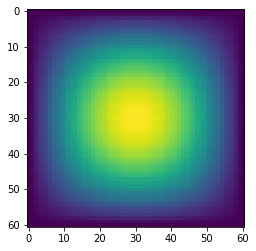

In [9]:
plt.imshow(UU)

In [22]:
import pygame
import numpy as np
import time

WIDTH, HEIGHT = 600, 600
nX, nY = 60, 60
xSize = WIDTH/nX
ySize = HEIGHT/nY

pygame.init() # Initialize PyGame

screen = pygame.display.set_mode([WIDTH,HEIGHT]) # Set size of screen

BG_COLOR = (221, 236, 248) # Define background color
LIVE_COLOR = (255,255,255)
DEAD_COLOR = (128,128,128)
# Celdas vivas = 1; Celdas muertas = 0
status = np.zeros((nX,nY)) # Intialize status of cells

for x in range(0,nX):
    for y in range(0,6):
        status[x,10*y]=1
        status[10*y,x]=1

pauseRun = True

running = True
while running:

    newStatus = np.copy(status) # Copy status

    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False

        if event.type == pygame.KEYDOWN:
            pauseRun = not pauseRun

        mouseClick = pygame.mouse.get_pressed()
        if sum(mouseClick) > 0:
            posX, posY = pygame.mouse.get_pos()
            x, y = int(np.floor(posX/xSize)), int(np.floor(posY/ySize))
            #newStatus[x,y] = np.abs(newStatus[x,y]-1)
            newStatus[x,y] = not mouseClick[2]
     
    screen.fill(BG_COLOR) # Clean background
    
    for x in range(0,nX):
        for y in range(0,nY):
            
            if not pauseRun:

                # Numero de vecinos
                nNeigh = status[(x-1)%nX,(y-1)%nY] + status[(x)%nX,(y-1)%nY] + \
                        status[(x+1)%nX,(y-1)%nY] + status[(x-1)%nX,(y)%nY] + \
                        status[(x+1)%nX,(y)%nY] + status[(x-1)%nX,(y+1)%nY] + \
                         status[(x)%nX,(y+1)%nY] + status[(x+1)%nX,(y+1)%nY]

                # Rule 1: Una celula muerta con 3 vecinas revive 
                if (status[x,y] == 0 and nNeigh==3 and (0.25 < UU[x,y] < 0.8)):
                    newStatus[x,y] = 1

                # Rule 2: Una celula viva con mas de 3 vecinos o menos de 2 muere                
                elif status[x,y] == 1 and (nNeigh < 2 or nNeigh > 3)and (0.25 > UU[x,y] or  UU[x,y] > 0.8):
                    newStatus[x,y] = 0


            poly = [(x*xSize,y*ySize),
                    ((x+1)*xSize,y*ySize),
                    ((x+1)*xSize,(y+1)*ySize),
                    (x*xSize,(y+1)*ySize)]

            if newStatus[x,y] == 1:
                pygame.draw.polygon(screen,LIVE_COLOR,poly,0)
            else:
                pygame.draw.polygon(screen,DEAD_COLOR,poly,1)

    status = np.copy(newStatus)
    time.sleep(0.1)
    pygame.display.flip()

pygame.quit()

In [24]:
import pygame
import numpy as np
import time

WIDTH, HEIGHT = 600, 600
nX, nY = 60, 60
xSize = WIDTH/nX
ySize = HEIGHT/nY

pygame.init() # Initialize PyGame

screen = pygame.display.set_mode([WIDTH,HEIGHT]) # Set size of screen

BG_COLOR = (221, 236, 248) # Define background color
LIVE_COLOR = (255,255,255)
DEAD_COLOR = (128,128,128)
# Celdas vivas = 1; Celdas muertas = 0
status = np.zeros((nX,nY)) # Intialize status of cells

for x in range(0,nX):
    for y in range(0,6):
        status[x,10*y]=1
        status[10*y,x]=1

pauseRun = True

running = True
while running:

    newStatus = np.copy(status) # Copy status

    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False

        if event.type == pygame.KEYDOWN:
            pauseRun = not pauseRun

        mouseClick = pygame.mouse.get_pressed()
        if sum(mouseClick) > 0:
            posX, posY = pygame.mouse.get_pos()
            x, y = int(np.floor(posX/xSize)), int(np.floor(posY/ySize))
            #newStatus[x,y] = np.abs(newStatus[x,y]-1)
            newStatus[x,y] = not mouseClick[2]
     
    screen.fill(BG_COLOR) # Clean background
    
    for x in range(0,nX):
        for y in range(0,nY):
            
            if not pauseRun:

                # Numero de vecinos
                nNeigh = status[(x-1)%nX,(y-1)%nY] + status[(x)%nX,(y-1)%nY] + \
                        status[(x+1)%nX,(y-1)%nY] + status[(x-1)%nX,(y)%nY] + \
                        status[(x+1)%nX,(y)%nY] + status[(x-1)%nX,(y+1)%nY] + \
                         status[(x)%nX,(y+1)%nY] + status[(x+1)%nX,(y+1)%nY]

                # Rule 1: Una celula muerta con 3 vecinas revive 
                if (status[x,y] == 0 and nNeigh==3 and (0< UU[x,y] < 0.5)):
                    newStatus[x,y] = 1

                # Rule 2: Una celula viva con mas de 3 vecinos o menos de 2 muere                
                elif status[x,y] == 1 and (nNeigh < 2 or nNeigh > 3)and ( UU[x,y] > 0.5):
                    newStatus[x,y] = 0


            poly = [(x*xSize,y*ySize),
                    ((x+1)*xSize,y*ySize),
                    ((x+1)*xSize,(y+1)*ySize),
                    (x*xSize,(y+1)*ySize)]

            if newStatus[x,y] == 1:
                pygame.draw.polygon(screen,LIVE_COLOR,poly,0)
            else:
                pygame.draw.polygon(screen,DEAD_COLOR,poly,1)

    status = np.copy(newStatus)
    time.sleep(0.1)
    pygame.display.flip()

pygame.quit()

In [25]:
import pygame
import numpy as np
import time

WIDTH, HEIGHT = 600, 600
nX, nY = 60, 60
xSize = WIDTH/nX
ySize = HEIGHT/nY

pygame.init() # Initialize PyGame

screen = pygame.display.set_mode([WIDTH,HEIGHT]) # Set size of screen

BG_COLOR = (221, 236, 248) # Define background color
LIVE_COLOR = (255,255,255)
DEAD_COLOR = (128,128,128)
# Celdas vivas = 1; Celdas muertas = 0
status = np.zeros((nX,nY)) # Intialize status of cells

for x in range(0,nX):
    for y in range(0,6):
        status[x,10*y]=1
        status[10*y,x]=1

pauseRun = True

running = True
while running:

    newStatus = np.copy(status) # Copy status

    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False

        if event.type == pygame.KEYDOWN:
            pauseRun = not pauseRun

        mouseClick = pygame.mouse.get_pressed()
        if sum(mouseClick) > 0:
            posX, posY = pygame.mouse.get_pos()
            x, y = int(np.floor(posX/xSize)), int(np.floor(posY/ySize))
            #newStatus[x,y] = np.abs(newStatus[x,y]-1)
            newStatus[x,y] = not mouseClick[2]
     
    screen.fill(BG_COLOR) # Clean background
    
    for x in range(0,nX):
        for y in range(0,nY):
            
            if not pauseRun:

                # Numero de vecinos
                nNeigh = status[(x-1)%nX,(y-1)%nY] + status[(x)%nX,(y-1)%nY] + \
                        status[(x+1)%nX,(y-1)%nY] + status[(x-1)%nX,(y)%nY] + \
                        status[(x+1)%nX,(y)%nY] + status[(x-1)%nX,(y+1)%nY] + \
                         status[(x)%nX,(y+1)%nY] + status[(x+1)%nX,(y+1)%nY]

                # Rule 1: Una celula muerta con 3 vecinas revive 
                if (status[x,y] == 0 and nNeigh==3 and (UU[x,y] > 0.5)):
                    newStatus[x,y] = 1

                # Rule 2: Una celula viva con mas de 3 vecinos o menos de 2 muere                
                elif status[x,y] == 1 and (nNeigh < 2 or nNeigh > 3)and ( UU[x,y] < 0.5):
                    newStatus[x,y] = 0


            poly = [(x*xSize,y*ySize),
                    ((x+1)*xSize,y*ySize),
                    ((x+1)*xSize,(y+1)*ySize),
                    (x*xSize,(y+1)*ySize)]

            if newStatus[x,y] == 1:
                pygame.draw.polygon(screen,LIVE_COLOR,poly,0)
            else:
                pygame.draw.polygon(screen,DEAD_COLOR,poly,1)

    status = np.copy(newStatus)
    time.sleep(0.1)
    pygame.display.flip()

pygame.quit()

In [23]:
import pygame
import numpy as np
import time

WIDTH, HEIGHT = 600, 600
nX, nY = 60, 60
xSize = WIDTH/nX
ySize = HEIGHT/nY

pygame.init() # Initialize PyGame

screen = pygame.display.set_mode([WIDTH,HEIGHT]) # Set size of screen

BG_COLOR = (221, 236, 248) # Define background color
LIVE_COLOR = (255,255,255)
DEAD_COLOR = (128,128,128)
# Celdas vivas = 1; Celdas muertas = 0
status = np.zeros((nX,nY)) # Intialize status of cells

for x in range(0,nX):
    for y in range(0,3):
        status[x,20*y]=1
        status[20*y,x]=1

pauseRun = True

running = True
while running:

    newStatus = np.copy(status) # Copy status

    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False

        if event.type == pygame.KEYDOWN:
            pauseRun = not pauseRun

        mouseClick = pygame.mouse.get_pressed()
        if sum(mouseClick) > 0:
            posX, posY = pygame.mouse.get_pos()
            x, y = int(np.floor(posX/xSize)), int(np.floor(posY/ySize))
            #newStatus[x,y] = np.abs(newStatus[x,y]-1)
            newStatus[x,y] = not mouseClick[2]
     
    screen.fill(BG_COLOR) # Clean background
    
    for x in range(0,nX):
        for y in range(0,nY):
            
            if not pauseRun:

                # Numero de vecinos
                nNeigh = status[(x-1)%nX,(y-1)%nY] + status[(x)%nX,(y-1)%nY] + \
                        status[(x+1)%nX,(y-1)%nY] + status[(x-1)%nX,(y)%nY] + \
                        status[(x+1)%nX,(y)%nY] + status[(x-1)%nX,(y+1)%nY] + \
                         status[(x)%nX,(y+1)%nY] + status[(x+1)%nX,(y+1)%nY]

                # Rule 1: Una celula muerta con 3 vecinas revive 
                if (status[x,y] == 0 and nNeigh==3 and (0< UU[x,y] < 0.5)):
                    newStatus[x,y] = 1

                # Rule 2: Una celula viva con mas de 3 vecinos o menos de 2 muere                
                elif status[x,y] == 1 and (nNeigh < 2 or nNeigh > 3)and ( UU[x,y] > 0.5):
                    newStatus[x,y] = 0


            poly = [(x*xSize,y*ySize),
                    ((x+1)*xSize,y*ySize),
                    ((x+1)*xSize,(y+1)*ySize),
                    (x*xSize,(y+1)*ySize)]

            if newStatus[x,y] == 1:
                pygame.draw.polygon(screen,LIVE_COLOR,poly,0)
            else:
                pygame.draw.polygon(screen,DEAD_COLOR,poly,1)

    status = np.copy(newStatus)
    time.sleep(0.1)
    pygame.display.flip()

pygame.quit()

In [11]:
import pygame
import numpy as np
import time

WIDTH, HEIGHT = 600, 600
nX, nY = 60, 60
xSize = WIDTH/nX
ySize = HEIGHT/nY

pygame.init() # Initialize PyGame

screen = pygame.display.set_mode([WIDTH,HEIGHT]) # Set size of screen

BG_COLOR = (221, 236, 248) # Define background color
LIVE_COLOR = (255,255,255)
DEAD_COLOR = (128,128,128)
# Celdas vivas = 1; Celdas muertas = 0
status = np.zeros((nX,nY)) # Intialize status of cells

for x in range(30,50):
    for y in range(30,50):
        status[x,y]=1


pauseRun = True

running = True
while running:

    newStatus = np.copy(status) # Copy status

    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            running = False

        if event.type == pygame.KEYDOWN:
            pauseRun = not pauseRun

        mouseClick = pygame.mouse.get_pressed()
        if sum(mouseClick) > 0:
            posX, posY = pygame.mouse.get_pos()
            x, y = int(np.floor(posX/xSize)), int(np.floor(posY/ySize))
            #newStatus[x,y] = np.abs(newStatus[x,y]-1)
            newStatus[x,y] = not mouseClick[2]
     
    screen.fill(BG_COLOR) # Clean background
    
    for x in range(0,nX):
        for y in range(0,nY):
            
            if not pauseRun:

                # Numero de vecinos
                nNeigh = status[(x-1)%nX,(y-1)%nY] + status[(x)%nX,(y-1)%nY] + \
                        status[(x+1)%nX,(y-1)%nY] + status[(x-1)%nX,(y)%nY] + \
                        status[(x+1)%nX,(y)%nY] + status[(x-1)%nX,(y+1)%nY] + \
                         status[(x)%nX,(y+1)%nY] + status[(x+1)%nX,(y+1)%nY]

                # Rule 1: Una celula muerta con 3 vecinas revive 
                if (status[x,y] == 0 and nNeigh==3 and (UU[x,y] > 0.5)):
                    newStatus[x,y] = 1

                # Rule 2: Una celula viva con mas de 3 vecinos o menos de 2 muere                
                elif status[x,y] == 1 and (nNeigh < 2 or nNeigh > 3)and ( UU[x,y] < 0.5):
                    newStatus[x,y] = 0


            poly = [(x*xSize,y*ySize),
                    ((x+1)*xSize,y*ySize),
                    ((x+1)*xSize,(y+1)*ySize),
                    (x*xSize,(y+1)*ySize)]

            if newStatus[x,y] == 1:
                pygame.draw.polygon(screen,LIVE_COLOR,poly,0)
            else:
                pygame.draw.polygon(screen,DEAD_COLOR,poly,1)

    status = np.copy(newStatus)
    time.sleep(0.1)
    pygame.display.flip()

pygame.quit()

## Otra función diferente

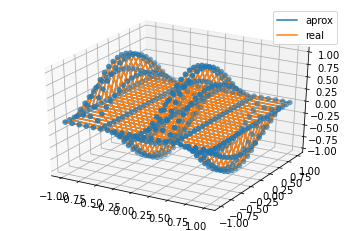

In [19]:
f1=lambda x: 17/4*(np.pi**2)*np.sin(2*np.pi*x)
f2= lambda y: np.cos(np.pi*y/2)
g = lambda x,y: np.sin(np.pi*2 *x)*np.cos(np.pi*y/2)

m=10
p=2
Nq=5
U=Solucion_2D(m,p,Nq,f1,f2)

fig = plt.figure()
ax = plt.axes(projection='3d')

i=[]
j=[]
real=[]
xvalss=np.linspace(-1,1,m*p+1)

for k in range(0,len(U)):
    i.append(xvalss[Indices(k,m*p)[0]])
    j.append(xvalss[Indices(k,m*p)[1]])
    real.append(g(i[k],j[k]))
    
ax.plot3D(i,j,U,label="aprox")
ax.scatter3D(i,j,U)
ax.plot3D(i,j,real,label="real")
plt.legend()
plt.show()   

In [20]:
err = U - real
print(f"Error ($||U-real||_\inf$): {max(abs(err))}")

Error ($||U-real||_\inf$): 0.0010331158259013762
